In [1]:
from google.colab import  drive
import os
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CAPSTONE//

Mounted at /content/drive
/content/drive/MyDrive/CAPSTONE


In [2]:
import numpy as np 
import pandas as pd 
import os, json
import glob
import csv

In [43]:
import io

actual_df = pd.read_csv("Articles2500_RemoveSW.csv")


In [4]:
!pip install --quiet transformers==4.5.0
# !pip install --quiet pytorch-lightning==1.2.7
!pip install sacrebleu
!pip install rouge
!pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2

     |████████████████████████████████| 2.1 MB 5.3 MB/s 
     |████████████████████████████████| 880 kB 47.3 MB/s 
     |████████████████████████████████| 3.3 MB 38.7 MB/s 
     |████████████████████████████████| 90 kB 4.4 MB/s 
     |████████████████████████████████| 6.9 MB 4.6 MB/s 
     |████████████████████████████████| 776.8 MB 16 kB/s 
     |████████████████████████████████| 816 kB 60.1 MB/s 
     |████████████████████████████████| 136 kB 52.0 MB/s 
     |████████████████████████████████| 596 kB 71.0 MB/s 
     |████████████████████████████████| 829 kB 54.5 MB/s 
     |████████████████████████████████| 1.1 MB 36.6 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 144 kB 60.0 MB/s 
     |████████████████████████████████| 271 kB 53.6 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=efb2bd6cc2eb7e92bb34ba711ba3af14c81d7668913942119c44a66027c32a65
  Stored in directory: /root/.cache/pip/wh

In [5]:
import json
import pandas as pd
import numpy as np
import torch
torch.cuda.empty_cache()
# path for data
from pathlib import Path
# dataset and dataloader for functions
from torch.utils.data import Dataset, DataLoader
# lightning for data class
import pytorch_lightning as pl
# leveraging the model checkpoints
from pytorch_lightning.callbacks import ModelCheckpoint
# we can visualize performance of model
from pytorch_lightning.loggers import TensorBoardLogger
# splitting the data
from sklearn.model_selection import train_test_split
# color formatting in ANSII code for output in terminal
from termcolor import colored
# wraps the paragraph into a single line or string
import textwrap
import sacrebleu
import rouge
# installing multiple utilities
# including optimizer , tokenizer and generation module
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)
# showing bars for processes in notebook
from tqdm.auto import tqdm

# random pseudo numbers
pl.seed_everything(42) 

df = actual_df[['abstract', 'body_text']]

# dropping out the Not Available values
df = df.dropna()
df=df.head(15000)
# using sklearn utility, splitting the data into 10:1 ratio
train_df, test_df = train_test_split(df, test_size=0.1)
train_df,valid_df = train_test_split(train_df,test_size=0.2)
# let's check the shape of our data
train_df.shape, valid_df.shape, test_df.shape 

 # class for creating the dataset which extends from pytorch 
class NewsSummaryDataset(Dataset):
   # init it , create a constructor
     def __init__(
         self,
         # data in the form of a dataframe
         data: pd.DataFrame,
         # a tokenizer
         tokenizer: T5Tokenizer,
         # max token length of input sequence
         text_max_token_len: int = 512,
         # same for the summary but less length
         summary_max_token_len: int = 128
     ):
         # saving all
         self.tokenizer = tokenizer
         self.data = data
         self.text_max_token_len = text_max_token_len
         self.summary_max_token_len = summary_max_token_len
     # length method
     def __len__(self):
         return len(self.data)
     # getting the items method  
     def __getitem__(self, index: int):
       # data row from data at current index
         data_row = self.data.iloc[index]
         # get the full text
         text = data_row['body_text']
         # encoding the text
         text_encoding = tokenizer(
             text,
             # setting max length
             max_length=self.text_max_token_len,
             # for same length
             padding='max_length',
             # cutting longer sequences
             truncation=True,
             # masking unwanted words
             return_attention_mask=True,
             # special tokens for start and end
             add_special_tokens=True,
             # return pytorch tensors
             return_tensors='pt'
         )
         # same is done with summary encoding
         summary_encoding = tokenizer(
             data_row['abstract'],
             truncation=True,
             return_attention_mask=True,
             add_special_tokens=True,
             max_length=self.summary_max_token_len,
             padding='max_length',
             return_tensors='pt'
         )
         # creating the actual labels
         labels = summary_encoding['input_ids'] 
         labels[labels == 0] = -100 # to make sure we have correct labels for T5 text generation
         return dict(
             # data
             text=text,
             # task
             summary=data_row['abstract'],
             # easy batching
             text_input_ids=text_encoding['input_ids'].flatten(),
             # masking
             text_attention_mask=text_encoding['attention_mask'].flatten(),
             # again flatten
             labels=labels.flatten(),
             labels_attention_mask=summary_encoding['attention_mask'].flatten()
         ) 

   # data module for pytorch lightning
class NewsSummaryDataModule(pl.LightningDataModule):
     def __init__(
         self,
         # pass in train data
         train_df: pd.DataFrame,
        # pass in validation data
         valid_df: pd.DataFrame,
         # pass in test data
         test_df: pd.DataFrame,
         # tokenizer
         tokenizer: T5Tokenizer,
         # batch_size
         batch_size: int = 1,
         # length of sequence
         text_max_token_len: int = 128,
         # length of output sequence
         summary_max_token_len: int = 64
     ):
         super().__init__()
         # storing the data in class objects
         self.train_df = train_df
         self.valid_df = valid_df
         self.test_df = test_df
         self.batch_size = batch_size
         self.tokenizer = tokenizer
         self.text_max_token_len = text_max_token_len
         self.summary_max_token_len = summary_max_token_len
     # automatically called by the trainer  
     def setup(self, stage=None):
         self.train_dataset = NewsSummaryDataset(
             self.train_df,
             self.tokenizer,
             self.text_max_token_len,
             self.summary_max_token_len
         )
         self.valid_dataset = NewsSummaryDataset(
             self.valid_df,
             self.tokenizer,
             self.text_max_token_len,
             self.summary_max_token_len
         )
         self.test_dataset = NewsSummaryDataset(
             self.test_df,
             self.tokenizer,
             self.text_max_token_len,
             self.summary_max_token_len
         )
     # for train data
     def train_dataloader(self):
         return DataLoader(
             self.train_dataset,
             batch_size=self.batch_size,
             shuffle=True,
             num_workers=2
         )
   # for test data
     def test_dataloader(self):
         return DataLoader(
             self.test_dataset,
             batch_size=self.batch_size,
             shuffle=True,
             num_workers=2
         )
     # valid data
     def val_dataloader(self):
         return DataLoader(
             self.valid_dataset,
             batch_size=self.batch_size,
             shuffle=True,
             num_workers=2
         ) 

# create lightning module for summarizatio
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
        self.train_loss = []
        self.test_loss = []
        self.valid_loss = []
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )
        return output.loss, output.logits
    def training_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']
        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )
        self.train_loss.append(loss.item())
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss
    def validation_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']
        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )
        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.valid_loss.append(loss.item())
        return loss
    def test_step(self, batch, batch_size):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']
        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )
        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.test_loss.append(loss.item())
        return loss
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001) 

def summarizeText(text):
     text_encoding = tokenizer(
         text,
         max_length=512,
         padding='max_length',
         truncation=True,
         return_attention_mask=True,
         add_special_tokens=True,
         return_tensors='pt'
     )
     generated_ids = trained_model.model.generate(
         input_ids=text_encoding['input_ids'],
         attention_mask=text_encoding['attention_mask'],
         max_length=150,
         num_beams=2,
         repetition_penalty=2.5,
         length_penalty=1.0,
         early_stopping=True
     )
     preds = [
             tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
             for gen_id in generated_ids
     ]
     return "".join(preds) 

def bleu(targets, predictions):
  """Computes BLEU score.
  Args:
    targets: list of strings or list of list of strings if multiple references
      are present.
    predictions: list of strings
  Returns:
    bleu_score across all targets and predictions
  """
  if isinstance(targets[0], list):
    targets = [[x for x in target] for target in targets]
  else:
    # Need to wrap targets in another list for corpus_bleu.
    targets = [targets]

  bleu_score = sacrebleu.corpus_bleu(predictions, targets,
                                     smooth_method="exp",
                                     smooth_value=0.0,
                                     force=False,
                                     lowercase=False,
                                     tokenize="intl",
                                     use_effective_order=False)
  return {"bleu": bleu_score.score}


def compute_rouge(predictions, targets):
    predictions = [" ".join(prediction).lower() for prediction in predictions]
    predictions = [prediction if prediction else "EMPTY" for prediction in predictions]
    targets = [" ".join(target).lower() for target in targets]
    targets = [target if target else "EMPTY" for target in targets]
    rouge = rouge.Rouge()
    scores = rouge.get_scores(hyps=predictions, refs=targets, avg=True)
    return scores

Global seed set to 42


In [6]:
# leveraging the base T5 transformer
MODEL_NAME = 't5-base'
# instantiate the tokenizer
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [7]:
N_EPOCHS = 1
BATCH_SIZE = 3
# call the data module
data_module = NewsSummaryDataModule(train_df,valid_df, test_df, tokenizer)
model = NewsSummaryModel()

checkpoint_callback = ModelCheckpoint(
     dirpath='checkpoints',
     filename='best-checkpoint',
     save_top_k=1,
     verbose=True,
     monitor='val_loss',
     mode='min'
 )
#  logger = TensorBoardLogger("lightning_logs", name='news-summary')
trainer = pl.Trainer(
  #  logger=logger,
    checkpoint_callback=checkpoint_callback,
    max_epochs=N_EPOCHS,
    gpus=0,
    
)

Downloading:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/892M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [8]:
trainer.fit(model, data_module)
trained_model = NewsSummaryModel.load_from_checkpoint(
     trainer.checkpoint_callback.best_model_path
 )
trained_model.freeze()
print(model.train_loss)


  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 1552: val_loss reached 2.66814 (best 2.66814), saving model to "/content/drive/MyDrive/CAPSTONE/checkpoints/best-checkpoint-v3.ckpt" as top 1


[4.1754655838012695, 4.026866436004639, 3.5404880046844482, 3.711221218109131, 3.1475367546081543, 4.2527384757995605, 3.1120171546936035, 3.067579507827759, 0.9996240139007568, 2.2606711387634277, 3.15670108795166, 4.351342678070068, 3.1446666717529297, 2.4832866191864014, 2.715374231338501, 0.8707005977630615, 3.6035282611846924, 3.35068941116333, 3.249368667602539, 3.6870222091674805, 2.3133482933044434, 2.812812089920044, 2.840914726257324, 5.4128923416137695, 3.2185163497924805, 3.128702163696289, 4.191730976104736, 0.5739681124687195, 3.3920352458953857, 3.564518451690674, 1.2775695323944092, 3.0437631607055664, 3.5696964263916016, 3.603986978530884, 3.1768691539764404, 4.522186279296875, 3.7181646823883057, 3.3413474559783936, 0.4261820316314697, 3.0992963314056396, 4.085808277130127, 0.6754051446914673, 2.1465225219726562, 4.35027551651001, 3.381258010864258, 4.476862907409668, 2.4815144538879395, 3.3510749340057373, 3.8013482093811035, 0.16135680675506592, 4.273840427398682, 3

In [9]:
train_loss = pd.Series(model.train_loss,name='train_loss')
valid_loss = pd.Series(model.valid_loss,name='valid_loss')

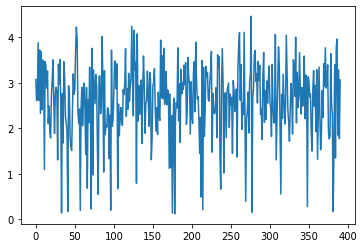

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.plot(valid_loss)
plt.show()

In [13]:
def compute_rouge(predictions, targets):
    # predictions = [" ".join(prediction).lower() for prediction in predictions]
    # predictions = [prediction if prediction else "EMPTY" for prediction in predictions]
    # targets = [" ".join(target).lower() for target in targets]
    # targets = [target if target else "EMPTY" for target in targets]
    rouge = Rouge()
    scores = rouge.get_scores(hyps=predictions, refs=targets, avg=True)
    return scores
 
def summarizeText(text):
     text_encoding = tokenizer(
         text,
         max_length=512,
         padding='max_length',
         truncation=True,
         return_attention_mask=True,
         add_special_tokens=True,
         return_tensors='pt'
     )
     generated_ids = trained_model.model.generate(
         input_ids=text_encoding['input_ids'],
         attention_mask=text_encoding['attention_mask'],
         max_length=150,
         num_beams=2,
         repetition_penalty=2.5,
         length_penalty=1.0,
         early_stopping=True
     )
     preds = [
             tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
             for gen_id in generated_ids
     ]
     return "".join(preds) 

def evaluation_metrics(test):
    pass

In [15]:
test_df['pred_summary'] = [summarizeText(summ) for summ in test_df['body_text']]



In [37]:
test_df

,abstract,body_text,pred_summary
1151,The COVID-19 pandemic provides an opportunity ...,23\n\nThe outbreak of the Corona Virus Disease...,BACKGROUND: The COVID-19 pandemic has negative...
416,"The novel coronavirus infection, COVID-19, is ...",Introduction\n\nThe novel coronavirus infectio...,"The novel coronavirus infection, otherwise kno..."
477,The ability to deal with uncertainty in machin...,"I. INTRODUCTION\n\nIn recent years, machine le...",BACKGROUND: The COVID-19 pandemic has led to t...
1288,Heparan Sulfate Proteoglycans (HSPGs) are impo...,INTRODUCTION\n\nHeparan Sulfate Proteoglycans ...,BACKGROUND: Heparan Sulfate Proteoglycans (HSP...
553,BACKGROUND: The Vesical Imaging-Reporting and ...,Introduction\n\nBladder cancer (BC) represents...,BACKGROUND: The use of multiparametric MRI (MR...
...,...,...,...
51,"During the COVID-19 crisis period, firms headq...",Introduction\n\nExisting literature documents ...,BACKGROUND: Social trust in the stock market i...
1350,Structural inequalities and identity processes...,\n\nIdentity processes related to structural i...,"BACKGROUND: In the COVID-19 pandemic, BAME (Bl..."
1491,OBJECTIVES: To examine whether patients with m...,"\n\nswelling or rash (99.9, ) and generalized ...",BACKGROUND: Multisystem inflammatory syndrome ...
1793,OBJECTIVE: This study aimed to identify the st...,Introduction\n\nVaccines have been necessary p...,Vaccines have been necessary public health too...


In [25]:
test_df.to_csv("summary_fulltext.csv")

In [28]:
sample_row = test_df.iloc[4]
text = sample_row['body_text']
model_summary = summarizeText(text)
print(text)
sample_row['abstract']
print("*************************************************************")

Introduction

Bladder cancer (BC) represents a real public health challenge. About 550,00 bladder cancer cases were diagnosed in 2018, worldwide. 1 One of the main challenges in bladder cancer management lies in the need to quickly distinguish between patients with non-muscle invasive BC (NMIBC) and patients with muscle invasive BC (MIBC). In Europe, the 5-year age-standardized relative survival rate of all BC was approximately 70%, ranging on average from 60% to 80% between countries. 2 Current imaging modalities such as ultrasound or computerized tomography urogram (CTU) have shown limited performance to assess muscle invasion. Despite this, the good overall sensitivity (about 90%) to diagnose BC with CT urography, NMIBC/MIBC discrimination remains challenging. [3] [4] [5] Therefore, the use of complementary investigations, especially with transurethral resection of bladder tumors (TURBT) is needed. To achieve such a goal, other imaging modalities should be further investigated. Magn

In [29]:
model_summary

'BACKGROUND: The use of multiparametric MRI (MRI) has been widely used in bladder cancer management. However, there is still a lack of data on the effectiveness of imaging and reporting for patients with non-muscle invasive BC (NMIBC) and patients with muscle invasive BC (MIBC). This paper presents'

In [35]:
from rouge import Rouge


In [42]:
res = compute_rouge(test_df['pred_summary'],test_df['abstract'])
res

{'rouge-1': {'f': 0.192961493002445,
  'p': 0.4358744580529072,
  'r': 0.12742530774028565},
 'rouge-2': {'f': 0.05362790167560433,
  'p': 0.14538919670614892,
  'r': 0.03397865171967206},
 'rouge-l': {'f': 0.17757308990561066,
  'p': 0.40211753882630036,
  'r': 0.11717427089441153}}